In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [2]:
vic_df = pd.read_csv('data/VIC.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
vic_df = vic_df.drop(columns=["Volume", "Open Interest"])

# Hiển thị lại DataFrame sau khi xóa
print(vic_df)

       Ticker         Date/Time   Open   High    Low  Close
0         VIC   10/17/2018 9:39   98.5   98.5   98.5   98.5
1         VIC   10/17/2018 9:40   98.5   98.5   98.5   98.5
2         VIC   10/17/2018 9:41   98.6   98.6   98.6   98.6
3         VIC   10/17/2018 9:42   98.6   98.6   98.6   98.6
4         VIC   10/17/2018 9:43   98.6   98.7   98.6   98.7
...       ...               ...    ...    ...    ...    ...
101261    VIC  12/22/2020 14:22  105.8  105.8  105.7  105.7
101262    VIC  12/22/2020 14:23  105.7  105.7  105.7  105.7
101263    VIC  12/22/2020 14:24  105.7  105.7  105.7  105.7
101264    VIC  12/22/2020 14:25  105.7  105.7  105.7  105.7
101265    VIC  12/22/2020 14:46  105.7  105.7  105.7  105.7

[101266 rows x 6 columns]


In [3]:
vic_df["Date/Time"] = pd.to_datetime(vic_df["Date/Time"],format="%m/%d/%Y %H:%M")

In [4]:
vic_df.shape

(101266, 6)

In [5]:
vic_df.head(5)

,Ticker,Date/Time,Open,High,Low,Close
0,VIC,2018-10-17 09:39:00,98.5,98.5,98.5,98.5
1,VIC,2018-10-17 09:40:00,98.5,98.5,98.5,98.5
2,VIC,2018-10-17 09:41:00,98.6,98.6,98.6,98.6
3,VIC,2018-10-17 09:42:00,98.6,98.6,98.6,98.6
4,VIC,2018-10-17 09:43:00,98.6,98.7,98.6,98.7


In [6]:
vic_df.sample(5)

,Ticker,Date/Time,Open,High,Low,Close
72185,VIC,2020-06-01 10:56:00,96.7,96.7,96.6,96.7
459,VIC,2018-10-19 11:25:00,98.2,98.2,98.1,98.1
98428,VIC,2020-12-03 10:53:00,104.9,104.9,104.9,104.9
61949,VIC,2020-03-18 11:17:00,88.1,88.1,88.0,88.0
16409,VIC,2019-03-06 10:19:00,117.4,117.5,117.4,117.5


In [7]:
vic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     101266 non-null  object        
 1   Date/Time  101266 non-null  datetime64[ns]
 2   Open       101266 non-null  float64       
 3   High       101266 non-null  float64       
 4   Low        101266 non-null  float64       
 5   Close      101266 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 4.6+ MB


In [8]:
vic_df.describe()

,Open,High,Low,Close
count,101266.000000,101266.000000,101266.000000,101266.000000
mean,105.376460,105.418519,105.334147,105.378791
std,11.543158,11.535584,11.552338,11.545054
min,68.000000,68.000000,68.000000,68.000000
25%,95.400000,95.400000,95.300000,95.400000
50%,105.300000,105.300000,105.200000,105.300000
75%,115.800000,115.900000,115.800000,115.800000
max,126.100000,126.500000,126.100000,126.500000


In [9]:
vic_df.isnull().sum()

Ticker       0
Date/Time    0
Open         0
High         0
Low          0
Close        0
dtype: int64

In [10]:
vic_df.duplicated().sum()

0

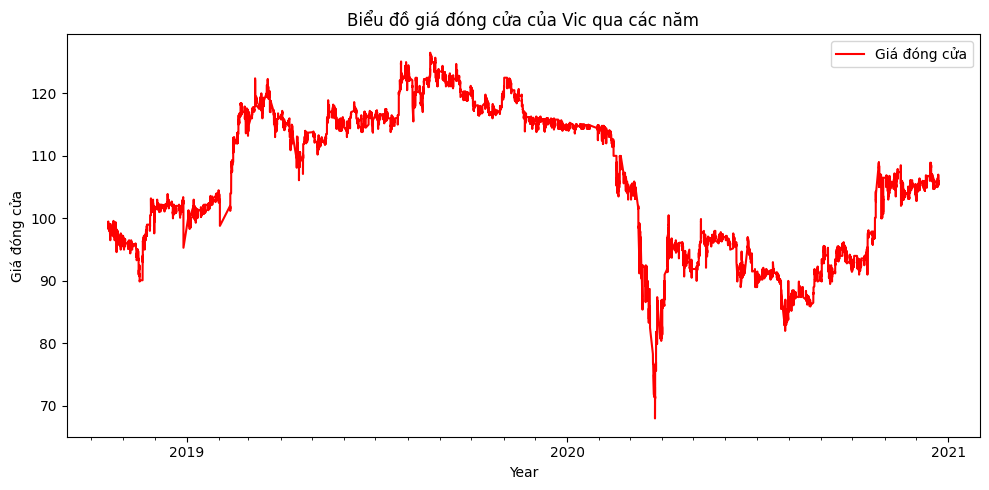

In [11]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
vic_df["Date/Time"] = pd.to_datetime(vic_df["Date/Time"],format="%m/%d/%Y %H:%M")

# Sắp xếp lại dữ liệu theo thứ tự thời gian
vic_df = vic_df.sort_values(by='Date/Time')

# Lấy thông tin năm từ cột "Ngày"
vic_df['Year'] = vic_df['Date/Time'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(vic_df['Date/Time'], vic_df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Year')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của Vic qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [12]:
vic_df['Year']

0         2018
1         2018
2         2018
3         2018
4         2018
          ... 
101261    2020
101262    2020
101263    2020
101264    2020
101265    2020
Name: Year, Length: 101266, dtype: int64

In [13]:
vic_df1 = pd.DataFrame(vic_df,columns=['Date/Time','Close'])
vic_df1.index = vic_df1['Date/Time']
vic_df1.drop('Date/Time',axis=1,inplace=True)
vic_df1

,Close
Date/Time,
2018-10-17 09:39:00,98.5
2018-10-17 09:40:00,98.5
2018-10-17 09:41:00,98.6
2018-10-17 09:42:00,98.6
2018-10-17 09:43:00,98.7
...,...
2020-12-22 14:22:00,105.7
2020-12-22 14:23:00,105.7
2020-12-22 14:24:00,105.7


In [14]:
data = vic_df1.values
train_data = data[:81012]
test_data = data[81012:]

In [15]:
data

array([[ 98.5],
       [ 98.5],
       [ 98.6],
       ...,
       [105.7],
       [105.7],
       [105.7]])

In [16]:
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)
sc_train

array([[0.52136752],
       [0.52136752],
       [0.52307692],
       ...,
       [0.64444444],
       [0.64444444],
       [0.64444444]])

In [17]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [18]:
x_train

[array([0.52136752, 0.52136752, 0.52307692, 0.52307692, 0.52478632,
        0.52478632, 0.52649573, 0.52478632, 0.52649573, 0.52649573,
        0.52478632, 0.52307692, 0.52307692, 0.52307692, 0.52136752,
        0.52307692, 0.52478632, 0.52478632, 0.52991453, 0.52649573,
        0.52991453, 0.53333333, 0.53846154, 0.52649573, 0.52820513,
        0.52820513, 0.53846154, 0.52991453, 0.52991453, 0.52991453,
        0.53162393, 0.53504274, 0.53675214, 0.53333333, 0.53333333,
        0.53333333, 0.53333333, 0.52991453, 0.52991453, 0.52991453,
        0.52991453, 0.52820513, 0.52649573, 0.52478632, 0.52478632,
        0.52478632, 0.52478632, 0.52478632, 0.52478632, 0.52478632]),
 array([0.52136752, 0.52307692, 0.52307692, 0.52478632, 0.52478632,
        0.52649573, 0.52478632, 0.52649573, 0.52649573, 0.52478632,
        0.52307692, 0.52307692, 0.52307692, 0.52136752, 0.52307692,
        0.52478632, 0.52478632, 0.52991453, 0.52649573, 0.52991453,
        0.53333333, 0.53846154, 0.52649573, 0.

In [19]:
y_train

[0.5264957264957266,
 0.5264957264957266,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5247863247863249,
 0.5247863247863249,
 0.5247863247863249,
 0.523076923076923,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.523076923076923,
 0.5213675213675215,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.5179487179487179,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.5179487179487179,
 0.5213675213675215,
 0.5179487179487179,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923

In [20]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [21]:
x_train

array([[[0.52136752],
        [0.52136752],
        [0.52307692],
        ...,
        [0.52478632],
        [0.52478632],
        [0.52478632]],

       [[0.52136752],
        [0.52307692],
        [0.52307692],
        ...,
        [0.52478632],
        [0.52478632],
        [0.52649573]],

       [[0.52307692],
        [0.52307692],
        [0.52478632],
        ...,
        [0.52478632],
        [0.52649573],
        [0.52649573]],

       ...,

       [[0.2974359 ],
        [0.2991453 ],
        [0.29230769],
        ...,
        [0.32136752],
        [0.31965812],
        [0.31965812]],

       [[0.2991453 ],
        [0.29230769],
        [0.27350427],
        ...,
        [0.31965812],
        [0.31965812],
        [0.32478632]],

       [[0.29230769],
        [0.27350427],
        [0.27350427],
        ...,
        [0.31965812],
        [0.32478632],
        [0.32478632]]])

In [22]:
y_train

array([[0.52649573],
       [0.52649573],
       [0.52307692],
       ...,
       [0.32478632],
       [0.32478632],
       [0.32478632]])

In [23]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
#huấn luyện mô hình
save_model = "C:\\Users\\Admin\\Documents\\Test_ML\\Stock prediction\\outputs\\save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04867, saving model to C:\Users\Admin\Documents\Test_ML\Stock prediction\outputs\save_model.keras
1620/1620 - 93s - 57ms/step - loss: 0.0487
Epoch 2/100

Epoch 2: loss improved from 0.04867 to 0.02217, saving model to C:\Users\Admin\Documents\Test_ML\Stock prediction\outputs\save_model.keras
1620/1620 - 84s - 52ms/step - loss: 0.0222
Epoch 3/100

Epoch 3: loss improved from 0.02217 to 0.01979, saving model to C:\Users\Admin\Documents\Test_ML\Stock prediction\outputs\save_model.keras
1620/1620 - 77s - 47ms/step - loss: 0.0198
Epoch 4/100

Epoch 4: loss improved from 0.01979 to 0.01934, saving model to C:\Users\Admin\Documents\Test_ML\Stock prediction\outputs\save_model.keras
1620/1620 - 77s - 48ms/step - loss: 0.0193
Epoch 5/100

Epoch 5: loss improved from 0.01934 to 0.01918, saving model to C:\Users\Admin\Documents\Test_ML\Stock prediction\outputs\save_model.keras
1620/1620 - 77s - 47ms/step - loss: 0.0192
Epoch 6/100

Epoch 6: loss im

1620/1620 - 94s - 58ms/step - loss: 0.0179
Epoch 62/100

Epoch 62: loss did not improve from 0.01784
1620/1620 - 85s - 52ms/step - loss: 0.0180
Epoch 63/100

Epoch 63: loss did not improve from 0.01784
1620/1620 - 89s - 55ms/step - loss: 0.0179
Epoch 64/100

Epoch 64: loss did not improve from 0.01784
1620/1620 - 88s - 54ms/step - loss: 0.0179
Epoch 65/100

Epoch 65: loss did not improve from 0.01784
1620/1620 - 84s - 52ms/step - loss: 0.0180
Epoch 66/100

Epoch 66: loss did not improve from 0.01784
1620/1620 - 87s - 54ms/step - loss: 0.0179
Epoch 67/100

Epoch 67: loss did not improve from 0.01784
1620/1620 - 85s - 53ms/step - loss: 0.0180
Epoch 68/100

Epoch 68: loss did not improve from 0.01784
1620/1620 - 83s - 51ms/step - loss: 0.0179
Epoch 69/100

Epoch 69: loss did not improve from 0.01784
1620/1620 - 83s - 51ms/step - loss: 0.0179
Epoch 70/100

Epoch 70: loss did not improve from 0.01784
1620/1620 - 86s - 53ms/step - loss: 0.0179
Epoch 71/100

Epoch 71: loss improved from 0.017

In [29]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("C:\\Users\\Admin\\Documents\\Test_ML\\Stock prediction\\outputs\\save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

2531/2531 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step


In [30]:
#xử lý dữ liệu test
test = vic_df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[81012:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

633/633 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_6364\492598317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
C:\Users\Admin\AppData\Local\Temp\ipykernel_6364\492598317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


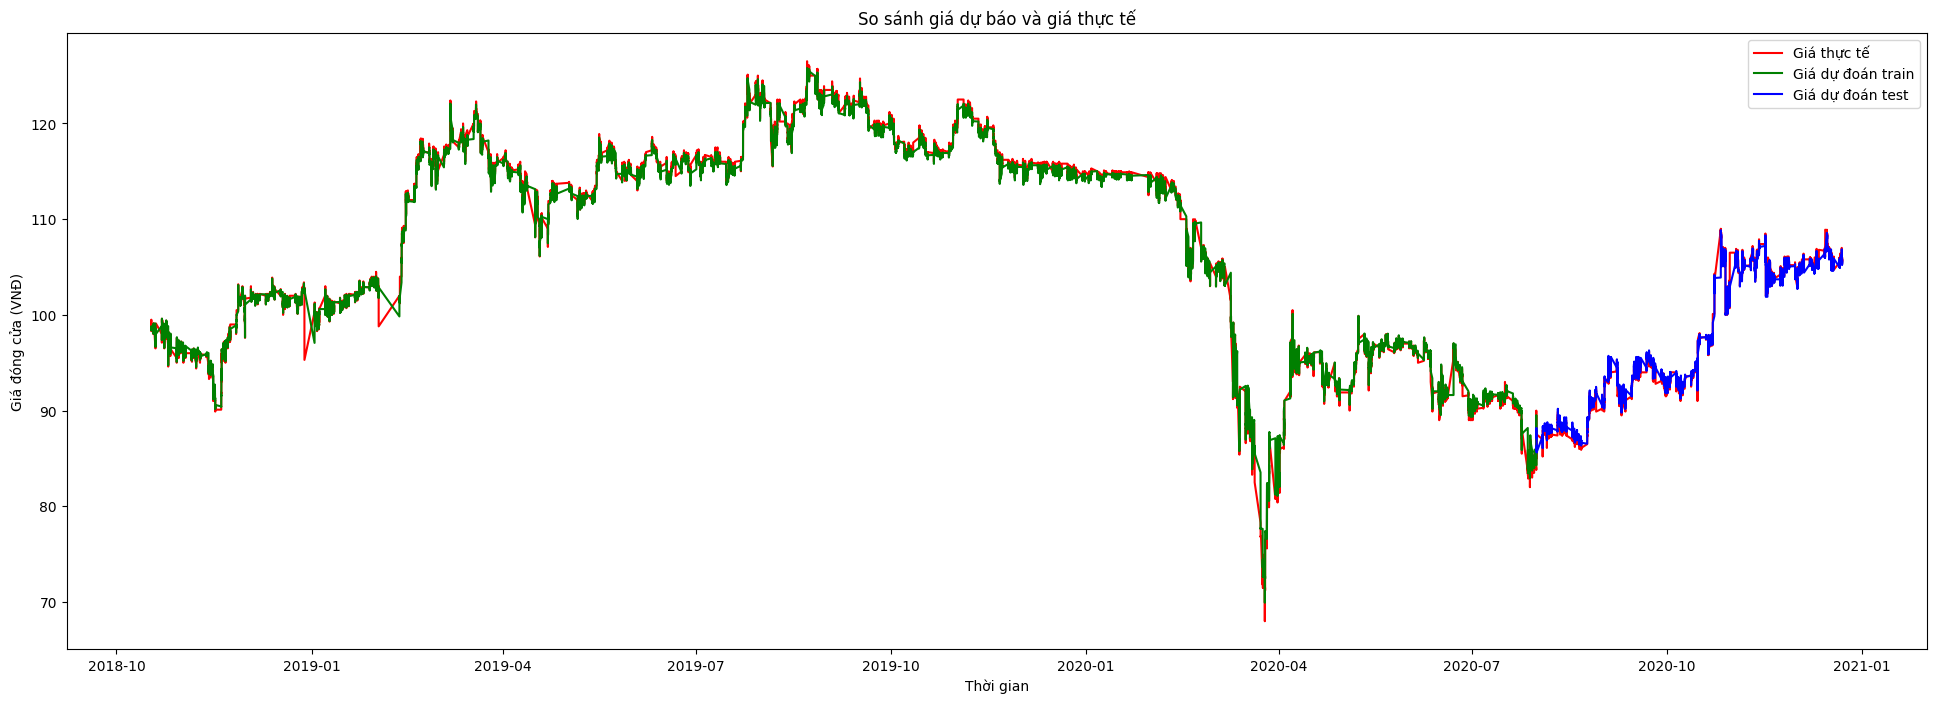

In [31]:
#lập biểu đồ so sánh
train_data1 = vic_df1[50:81012]
test_data1 = vic_df1[81012:]

plt.figure(figsize=(24,8))
plt.plot(vic_df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [32]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: -83.94803216392783
Sai số tuyệt đối trung bình trên tập train (VNĐ): 6238.347022735843
Phần trăm sai số tuyệt đối trung bình tập train: 0.9831019485782577


In [33]:
train_data1

,Close,Dự đoán
Date/Time,,
2018-10-17 10:36:00,98.8,98.720375
2018-10-17 10:37:00,98.8,98.794731
2018-10-17 10:40:00,98.6,98.818520
2018-10-17 10:41:00,98.6,98.675751
2018-10-17 10:42:00,98.6,98.629242
...,...,...
2020-07-31 10:02:00,86.7,87.235962
2020-07-31 10:03:00,86.7,87.128853
2020-07-31 10:04:00,87.0,87.092743


In [34]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9985092721668936
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.20826589373971569
Phần trăm sai số tuyệt đối trung bình tập test: 0.002195740623211963


In [35]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-07-31 10:08:00,86.8,87.400314
2020-07-31 10:09:00,86.8,87.243790
2020-07-31 10:10:00,86.8,87.195053
2020-07-31 10:11:00,86.8,87.184120
2020-07-31 10:12:00,86.7,87.187035
...,...,...
2020-12-22 14:22:00,105.7,105.676399
2020-12-22 14:23:00,105.7,105.605614
2020-12-22 14:24:00,105.7,105.582047


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


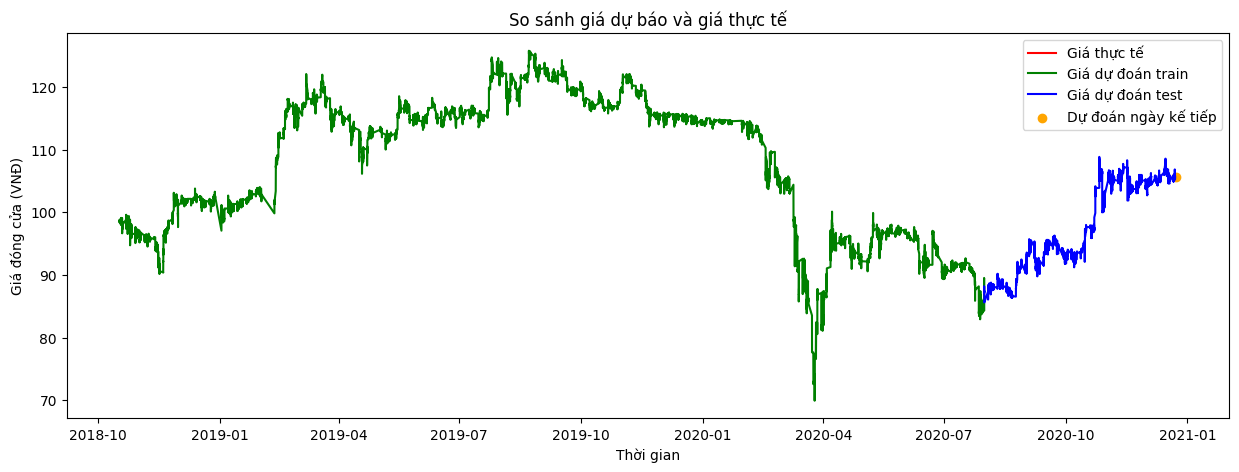

In [37]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = vic_df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([vic_df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
vic_df1 = pd.concat([vic_df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(vic_df1['Date/Time'], vic_df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [51]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = vic_df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Date/Time': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

            Date/Time  Giá dự đoán  Giá ngày trước
0 2020-12-23 14:46:00   105.577499           105.7


In [49]:
y_next_predict

array([[105.5775]], dtype=float32)